In [1]:
import os
import tensorflow as tf
import numpy as np

from transformers import BertTokenizer, TFBertModel

In [5]:
import matplotlib.pyplot as plt

## Prepare aligned sentence pairs

In [6]:
l1 = 'de'
l2 = 'en'
l_pair = f"{l1}-{l2}"

gold_alignment = list()
with open(f'bucc2017/{l_pair}/{l_pair}.sample.gold', 'r') as in_file:
    for line in in_file.readlines(): 
        l1_tag, l2_tag = line.strip().split('\t')
        gold_alignment.append((l1_tag, l2_tag)) 
        

l1_2sent = dict()
with open(f'bucc2017/{l_pair}/{l_pair}.sample.{l1}', 'r') as l1_in:
    for line in l1_in.readlines():
        l1_tag, l1_sent = line.strip().split('\t')
        l1_2sent[l1_tag] = l1_sent
        
l2_2sent = dict()
with open(f'bucc2017/{l_pair}/{l_pair}.sample.{l2}', 'r') as l2_in:
    for line in l2_in.readlines():
        l2_tag, l2_sent = line.strip().split('\t')
        l2_2sent[l2_tag] = l2_sent
        
    
        
l1_list = []
l2_list = []
for l1_tag, l2_tag in gold_alignment:
    l1_list.append(l1_2sent[l1_tag])
    l2_list.append(l2_2sent[l2_tag])

FileNotFoundError: [Errno 2] No such file or directory: 'bucc2017/de-en/de-en.sample.gold'

## Initialize BERT model

In [7]:
bert_path = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(bert_path, do_lower_case=False)

bert_model = TFBertModel.from_pretrained(bert_path, output_hidden_states=True)

layer_idx = 6 

In [8]:
def get_embeddings(tokenizer, bert_model, layer_idx, sent_list):
    bert_input = tokenizer.batch_encode_plus(sent_list, pad_to_max_length=True)
    input_ids = tf.constant(bert_input['input_ids'])
    attn_masks =  tf.constant(bert_input['attention_mask'])

    data = tf.data.Dataset.from_tensor_slices((input_ids, attn_masks))

    emb_list = []
    for input_batch, attn_batch in data.batch(20):
        _, _, embs = bert_model(input_batch, attention_mask=attn_batch)
        mean_mask = tf.expand_dims(tf.cast(tf.pad(attn_batch[:,2:], [[0,0], [1,1]]), tf.float32),2)
        embs = tf.reduce_mean(embs[layer_idx + 1]*mean_mask, axis=1)
        emb_list.append(embs)

    return tf.concat(emb_list, axis=0).numpy()
    

In [9]:
l1_embeddings = get_embeddings(tokenizer, bert_model, layer_idx, l1_list)

NameError: name 'l1_list' is not defined

In [86]:
l2_embeddings = get_embeddings(tokenizer, bert_model, layer_idx, l2_list)

In [10]:
bert_input = tokenizer.batch_encode_plus(l1_list, pad_to_max_length=True)
input_ids = tf.constant(bert_input['input_ids'])
attn_masks =  tf.constant(bert_input['attention_mask'])

NameError: name 'l1_list' is not defined

In [17]:
data = tf.data.Dataset.from_tensor_slices((input_ids, attn_masks))

In [11]:

_, _, embs = bert_model(input_ids[0:1], attention_mask=attn_masks[0:1])

NameError: name 'input_ids' is not defined

## Alignment expermients

In [87]:
def calc_alignment_accuracy(src_embeddings, tgt_embeddings):
    distance_matrix = src_embeddings @ tgt_embeddings.transpose()
    distance_matrix = distance_matrix / np.linalg.norm(src_embeddings, axis=1, keepdims=True) 
    distance_matrix = distance_matrix / np.linalg.norm(tgt_embeddings.transpose(), axis=0, keepdims=True)
    
    retived_idcs = np.argmax(distance_matrix, axis=1)
    
    src_errors = np.where(np.arange(len(retived_idcs)) != retived_idcs)
    tgt_errors = retived_idcs[src_errors]
    
    return np.mean(np.arange(len(retived_idcs)) == retived_idcs), src_errors[0], tgt_errors

def pint_error_examples(src_errors, tgt_errors, src_list, tgt_list, n_exmpl=5):
    for s_e, t_e in zip(src_errors[:n_exmpl], tgt_errors[:n_exmpl]):
        print(f"For sentence:\t{src_list[s_e]}")
        print(f"retived:\t{tgt_list[t_e]}")
        print(f"should be:\t{tgt_list[s_e]}\n")
    

### DE/FR -> EN retival

In [88]:
xx2en_acc, src_e, tgt_e = calc_alignment_accuracy(l1_embeddings, l2_embeddings)

In [89]:
print(xx2en_acc)

0.9682080924855492


de -> en 92.8%

fr -> en 90.7%

score is already quite high with BERT alone
example of errors:

In [90]:
pint_error_examples(src_e, tgt_e, l1_list, l2_list)

For sentence:	Allein in den letzten zwölf Jahren ist die Weltbevölkerung um eine Milliarde Menschen gewachsen.
retived:	Over the past few decades, an estimated two billion people have risen into the middle class worldwide.
should be:	A billion people joined the human race in just the last 12 years.

For sentence:	Die Weltbevölkerung, so wird erwartet, soll bis 2042 auf neun Milliarden Menschen ansteigen.
retived:	By 2050, the global human population is expected to exceed nine billion.
should be:	The world’s population is expected to reach nine billion by 2042.

For sentence:	Noch nie seit dem Zweiten Weltkrieg war die Kaufkraft der amerikanischen Verbraucher so schwach.
retived:	The US federal government’s borrowing exceeded tax revenues in every year since the end of World War II.
should be:	Never before in the post-World War II era have American consumers been so weak for so long.

For sentence:	Ein zu langsames Tempo wäre unglaubwürdig; ein zu schnelles Tempo würde das Wachstum abwü

### EN -> DE retival

In [91]:
en2xx_acc, src_e, tgt_e = calc_alignment_accuracy(l2_embeddings, l1_embeddings)

In [92]:
print(en2xx_acc)

0.9749518304431599


en -> de 89.7%

en -> fr 90.3%


score for this direction is lower but still close to 90%

In [93]:
pint_error_examples(src_e, tgt_e, l2_list, l1_list)

For sentence:	A billion people joined the human race in just the last 12 years.
retived:	In den nächsten 25 Jahren werden weitere zwei Milliarden Menschen die Entwicklungsländer bevölkern.
should be:	Allein in den letzten zwölf Jahren ist die Weltbevölkerung um eine Milliarde Menschen gewachsen.

For sentence:	If that country is large, the shock waves could push other members over the edge with it.
retived:	Und chinesische Künstler werden auf internationalen Kunstauktionen Preise erzielen, von denen andere nur träumen können.
should be:	Wenn es sich dabei um ein großes Land handelt, könnten die Schockwellen auch andere Mitgliedsländer treffen.

For sentence:	Indeed, non-working time even for those who hold jobs is increasing, offering ample opportunity to rear children.
retived:	Aber wie die Regierung zusätzliche Arbeitsplätze für Frauen schaffen will, ist weniger klar.
should be:	Die Arbeitszeit wird für Arbeitnehmer immer kürzer und es wäre eigentlich genug Zeit da, Kinder groß zu zi

# With probe Language Specific matrices (Non orthogonal; depth probe)

In [94]:
languages = ['en', 'fr', 'de']
out_dir = f'experiments/train_en_de_fr/task_depth-layer_{layer_idx}-trainl_en_de_fr/'
model_dim = 768
probe_rank = 768




DistanceProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
                             ((probe_rank, model_dim)),
                             trainable=True, name='distance_probe', dtype=tf.float32)

DepthProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
                             ((probe_rank, model_dim)),
                             trainable=True, name='depth_probe', dtype=tf.float32)

optimizer=tf.optimizers.Adam()

LanguageMaps = {lang: tf.Variable(tf.initializers.Identity(gain=1.0)((model_dim, model_dim)),
                                               trainable=False, name='{}_map'.format(lang))
                             for lang in languages}
                
ckpt = tf.train.Checkpoint(optimizer=optimizer, depth_probe=DepthProbe, distance_probe=DistanceProbe, **LanguageMaps)

checkpoint_manger = tf.train.CheckpointManager(ckpt, os.path.join(out_dir, 'params'), max_to_keep=1)

checkpoint_manger.restore_or_initialize()

'experiments/train_en_de_fr/task_depth-layer_6-trainl_en_de_fr/params/ckpt-18'

In [95]:
l1_projections =  l1_embeddings @ ckpt.de.numpy()
l2_projections = l2_embeddings @ ckpt.en.numpy()

### DE2EN

In [96]:
de2en_proj_acc , src_e, tgt_e = calc_alignment_accuracy(l1_projections, l2_projections)
print(de2en_proj_acc)

0.05684007707129094


de -> en 11.9%

fr -> en  18.5%

Unexpectedly, the results after projection are poor, maybe this is because proj. matrix is not orthogonal.


### EN2DE

In [97]:
en2de_proj_acc , src_e, tgt_e = calc_alignment_accuracy(l2_projections, l1_projections)
print(en2de_proj_acc)

0.0953757225433526


de -> en 9.1%

fr -> en  14.4%

# Distance probe (Non Orthogonal LSM)

In [35]:
languages = ['en', 'fr', 'de']
out_dir = f'experiments/train_en_de_fr/task_distance-layer_{layer_idx}-trainl_en_de_fr/'
model_dim = 768
probe_rank = 768




DistanceProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
                             ((probe_rank, model_dim)),
                             trainable=True, name='distance_probe', dtype=tf.float32)

DepthProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
                             ((probe_rank, model_dim)),
                             trainable=True, name='depth_probe', dtype=tf.float32)

optimizer=tf.optimizers.Adam()

LanguageMaps = {lang: tf.Variable(tf.initializers.Identity(gain=1.0)((model_dim, model_dim)),
                                               trainable=False, name='{}_map'.format(lang))
                             for lang in languages}
                
ckpt = tf.train.Checkpoint(optimizer=optimizer, depth_probe=DepthProbe, distance_probe=DistanceProbe, **LanguageMaps)

checkpoint_manger = tf.train.CheckpointManager(ckpt, os.path.join(out_dir, 'params'), max_to_keep=1)

checkpoint_manger.restore_or_initialize()

'experiments/train_en_de_fr/task_distance-layer_6-trainl_en_de_fr/params/ckpt-25'

In [36]:
l1_projections =  l1_embeddings @ ckpt.de.numpy()
l2_projections = l2_embeddings @ ckpt.en.numpy()

In [37]:
de2en_proj_acc , src_e, tgt_e = calc_alignment_accuracy(l1_projections, l2_projections)
print(de2en_proj_acc)

0.02119460500963391


In [38]:
en2de_proj_acc , src_e, tgt_e = calc_alignment_accuracy(l2_projections, l1_projections)
print(en2de_proj_acc)

0.030828516377649325


## Takeaways

Non orthogonal language specific matrix hinder the mBERT performance in parallel sentence retrival. 

It might be because, when not restricted to be orthogonal language specific matrices take over part of probe matrices.

## Orthogonal matrix (depth probe)

In [98]:
#languages = ['en', 'fr', 'de']
languages = ["en", "de", "es", "fi", "pl", "ar", "id", "zh", "ko"]
#out_dir = f'experiments/train_en_de_fr_ortho/task_depth-layer_{layer_idx}-trainl_en_de_fr/'
out_dir = f'experiments/train_9_langs/task_depth-layer_{layer_idx}-trainl_en_de_es_fi_pl_ar_id_zh_ko/'

model_dim = 768
probe_rank = 768

DistanceProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
                             ((1, probe_rank)),
                             trainable=True, name='distance_probe', dtype=tf.float32)

DepthProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
                             ((1, probe_rank)),
                             trainable=True, name='depth_probe', dtype=tf.float32)

# DistanceProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.5, maxval=0.5, seed=42)
#                                 ((1, probe_rank,)),
#                                 trainable=True, name='distance_probe', dtype=tf.float32)

# DepthProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.5, maxval=0.5, seed=42)
#                                 ((1, probe_rank,)),
#                                 trainable=True, name='depth_probe', dtype=tf.float32)

optimizer=tf.optimizers.Adam()

LanguageMaps = {lang: tf.Variable(tf.initializers.Identity(gain=1.0)((model_dim, model_dim)),
                                               trainable=False, name='{}_map'.format(lang))
                             for lang in languages}



                
ckpt = tf.train.Checkpoint(optimizer=optimizer, depth_probe=DepthProbe, distance_probe=DistanceProbe, **LanguageMaps)

checkpoint_manger = tf.train.CheckpointManager(ckpt, os.path.join(out_dir, 'params'), max_to_keep=1)

checkpoint_manger.restore_or_initialize()

'experiments/train_9_langs/task_depth-layer_6-trainl_en_de_es_fi_pl_ar_id_zh_ko/params/ckpt-10'

In [117]:
l1_projections =  l1_embeddings @ ckpt.de.numpy()
l2_projections = l2_embeddings @ ckpt.en.numpy()

In [110]:
l1_projections =  l1_embeddings @ ckpt.de.numpy() * (np.abs(ckpt.depth_probe.numpy()) < 1e-35)
l2_projections = l2_embeddings @ ckpt.en.numpy() * (np.abs(ckpt.depth_probe.numpy()) < 1e-35)

In [120]:
l1_projections =  l1_embeddings @ ckpt.de.numpy() * ckpt.depth_probe.numpy()
l2_projections = l2_embeddings @ ckpt.en.numpy() * ckpt.depth_probe.numpy()

In [114]:
de_map_depth = ckpt.de.numpy()
en_map_depth = ckpt.en.numpy()

In [121]:
xx2en_proj_acc , src_e, tgt_e = calc_alignment_accuracy(l1_projections, l2_projections)
print(xx2en_proj_acc)

0.008670520231213872


In [122]:
en2xx_proj_acc , src_e, tgt_e = calc_alignment_accuracy(l2_projections, l1_projections)
print(en2xx_proj_acc)

0.002890173410404624


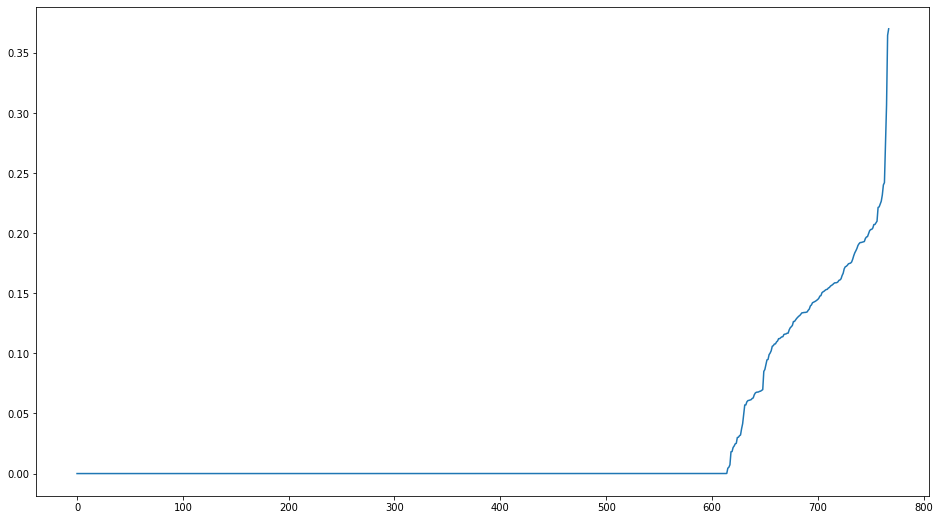

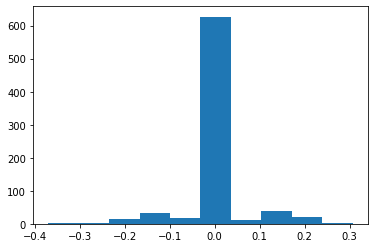

In [104]:
depth_probe_eigen = ckpt.depth_probe.numpy().ravel()

plt.figure(figsize=[16,9])
plt.plot(np.sort(np.abs(depth_probe_eigen)))
plt.show()
plt.hist(depth_probe_eigen)
plt.show()

## Orthogonal matrix (distance probe)

In [123]:
#languages = ['en', 'fr', 'de']
languages = ["en", "de", "es", "fi", "pl", "ar", "id", "zh", "ko"]
#out_dir = f'experiments/train_en_de_fr_ortho/task_depth-layer_{layer_idx}-trainl_en_de_fr/'
out_dir = f'experiments/train_9_langs/task_distance-layer_{layer_idx}-trainl_en_de_es_fi_pl_ar_id_zh_ko/'

model_dim = 768
probe_rank = 768

# DistanceProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
#                              ((1, probe_rank)),
#                              trainable=True, name='distance_probe', dtype=tf.float32)

# DepthProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
#                              ((1, probe_rank)),
#                              trainable=True, name='depth_probe', dtype=tf.float32)

DistanceProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.5, maxval=0.5, seed=42)
                                ((1, probe_rank,)),
                                trainable=True, name='distance_probe', dtype=tf.float32)

DepthProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.5, maxval=0.5, seed=42)
                                ((1, probe_rank,)),
                                trainable=True, name='depth_probe', dtype=tf.float32)

optimizer=tf.optimizers.Adam()

LanguageMaps = {lang: tf.Variable(tf.initializers.Identity(gain=1.0)((model_dim, model_dim)),
                                               trainable=False, name='{}_map'.format(lang))
                             for lang in languages}




                
ckpt = tf.train.Checkpoint(optimizer=optimizer, depth_probe=DepthProbe, distance_probe=DistanceProbe, **LanguageMaps)

checkpoint_manger = tf.train.CheckpointManager(ckpt, os.path.join(out_dir, 'params'), max_to_keep=1)

checkpoint_manger.restore_or_initialize()

'experiments/train_9_langs/task_distance-layer_6-trainl_en_de_es_fi_pl_ar_id_zh_ko/params/ckpt-11'

In [132]:
l1_projections =  l1_embeddings @ ckpt.de.numpy()
l2_projections = l2_embeddings @ ckpt.en.numpy()

In [142]:
l1_projections =  l1_embeddings @ ckpt.de.numpy() * (np.abs(ckpt.distance_probe.numpy()) < 0.01)
l2_projections = l2_embeddings @ ckpt.en.numpy() * (np.abs(ckpt.distance_probe.numpy()) < 0.01)

In [131]:
l1_projections =  l1_embeddings @ ckpt.de.numpy() * ckpt.distance_probe.numpy()
l2_projections = l2_embeddings @ ckpt.en.numpy() * ckpt.distance_probe.numpy()

In [263]:
(np.abs(ckpt.distance_probe.numpy()) > 0.1).shape

(1, 768)

In [125]:
de_map_distance = ckpt.de.numpy()
en_map_distance = ckpt.en.numpy()

In [143]:
xx2en_proj_acc , src_e, tgt_e = calc_alignment_accuracy(l1_projections, l2_projections)
print(xx2en_proj_acc)

0.8352601156069365


In [144]:
en2xx_proj_acc , src_e, tgt_e = calc_alignment_accuracy(l2_projections, l1_projections)
print(en2xx_proj_acc)

0.8747591522157996


In [270]:
ckpt.distance_probe.numpy()

array([[-4.23079530e-36, -2.32030417e-36, -3.52827671e-36,
        -3.05523932e-01, -1.48180187e-01, -2.03733640e-36,
        -4.90872027e-36,  4.94195216e-36, -3.04273312e-36,
        -9.02260914e-02,  7.59169608e-02,  1.99705183e-36,
         2.48505934e-35,  1.75912256e-36, -2.30595379e-36,
        -4.14789368e-36, -6.50782020e-37,  6.18892395e-36,
         2.07561466e-35, -1.91470552e-36, -1.02845892e-01,
         3.82503236e-36,  1.05447274e-36,  1.85153562e-36,
         7.19069496e-36,  9.62383625e-37, -2.58858794e-37,
        -4.22114109e-36, -6.23372317e-36, -1.09107134e-36,
        -2.51493533e-36, -2.84886193e-36,  1.71993703e-01,
         4.21805779e-36, -3.70953667e-36, -1.28309676e-36,
         1.53762072e-36,  1.74009472e-01, -8.24043853e-37,
        -1.19594529e-01,  7.55769812e-38,  1.65817992e-36,
         3.38025368e-36,  8.60720649e-02,  1.96668789e-01,
        -2.28594191e-36,  1.52146503e-01, -1.84261858e-01,
        -2.36395831e-36, -8.64691138e-02, -4.15551889e-3

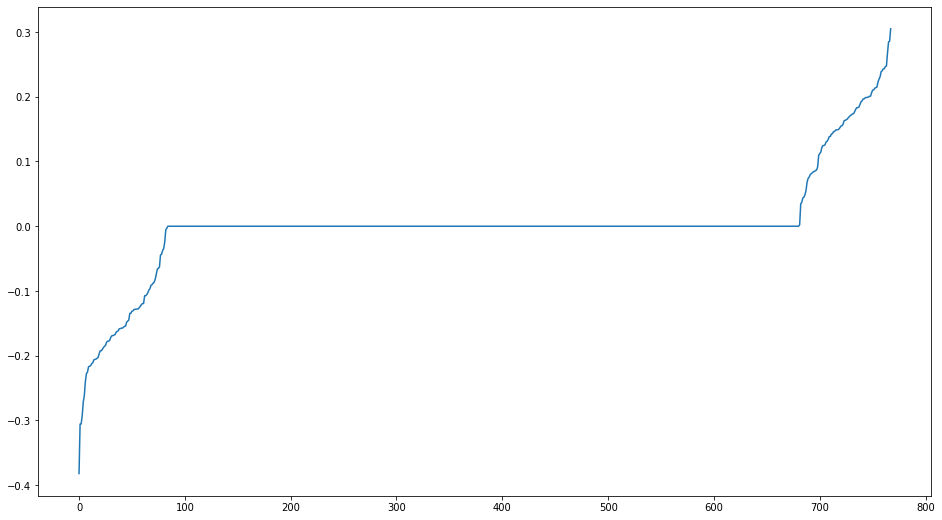

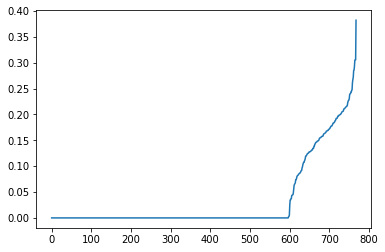

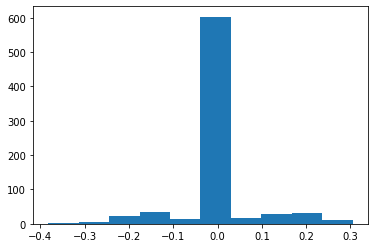

In [96]:
distance_probe_eigen = ckpt.distance_probe.numpy().ravel()

plt.figure(figsize=[16,9])

plt.plot(np.sort(distance_probe_eigen))
plt.show()
plt.plot(np.sort(np.abs(distance_probe_eigen)))
plt.show()
plt.hist(distance_probe_eigen)
plt.show()

## mean matrices

In [122]:
de_map = (de_map_depth + de_map_distance)/ 2.
en_map = (en_map_depth + en_map_distance)/2.

In [123]:
l1_projections =  l1_embeddings @ de_map
l2_projections = l2_embeddings @ en_map

In [124]:
xx2en_proj_acc , src_e, tgt_e = calc_alignment_accuracy(l1_projections, l2_projections)
print(xx2en_proj_acc)

0.8448940269749519


In [125]:
en2xx_proj_acc , src_e, tgt_e = calc_alignment_accuracy(l2_projections, l1_projections)
print(en2xx_proj_acc)

0.7947976878612717


## Lexical Depth Probe

In [12]:

languages = ["en"]
out_dir = f'experiments/task_lex-depth-layer_6-trainl_en/'

model_dim = 768
probe_rank = 768

# DistanceProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
#                              ((1, probe_rank)),
#                              trainable=True, name='distance_probe', dtype=tf.float32)

# DepthProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
#                              ((1, probe_rank)),
#                              trainable=True, name='depth_probe', dtype=tf.float32)

DistanceProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.5, maxval=0.5, seed=42)
                                ((1, probe_rank,)),
                                trainable=True, name='distance_probe', dtype=tf.float32)

DepthProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.5, maxval=0.5, seed=42)
                                ((1, probe_rank,)),
                                trainable=True, name='depth_probe', dtype=tf.float32)

optimizer=tf.optimizers.Adam()

LanguageMaps = {lang: tf.Variable(tf.initializers.Identity(gain=1.0)((model_dim, model_dim)),
                                               trainable=False, name='{}_map'.format(lang))
                             for lang in languages}




                
ckpt = tf.train.Checkpoint(optimizer=optimizer, depth_probe=DepthProbe, distance_probe=DistanceProbe, **LanguageMaps)

checkpoint_manger = tf.train.CheckpointManager(ckpt, os.path.join(out_dir, 'params'), max_to_keep=1)

checkpoint_manger.restore_or_initialize()

'experiments/task_lex-depth-layer_6-trainl_en/params/ckpt-10'

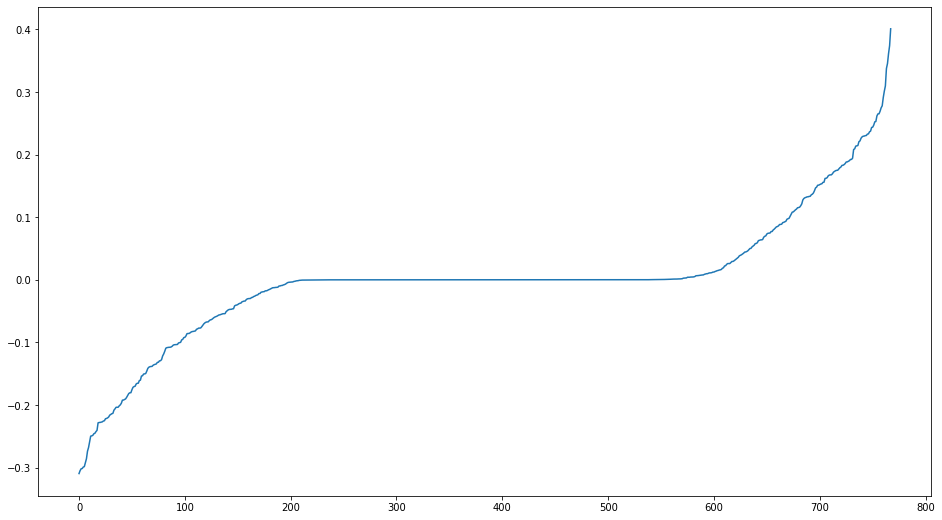

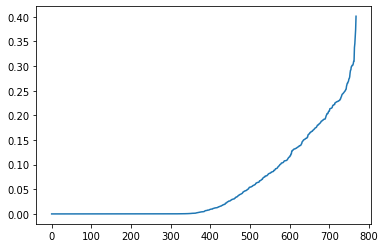

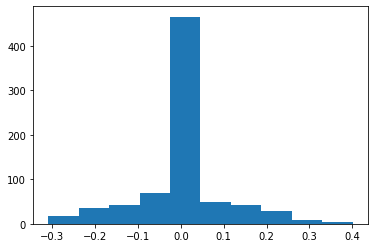

In [15]:
depth_probe_eigen = ckpt.depth_probe.numpy().ravel()

plt.figure(figsize=[16,9])

plt.plot(np.sort(depth_probe_eigen))
plt.show()
plt.plot(np.sort(np.abs(depth_probe_eigen)))
plt.show()
plt.hist(depth_probe_eigen)
plt.show()

it seams that lexical probing require more dimension. Another reason why their number is higher is that the training here was set to only 10 epochs.